In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144439 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive")
if("Colab Notebooks" in os.listdir()):
  os.chdir("Colab Notebooks")
else:
  os.mkdir("Colab Notebooks")
  os.chdir("Colab Notebooks")
os.chdir("AIMango")
os.chdir("C1-P1_Train Dev_fixed")

In [0]:
# 設定顯示中文字體
#from matplotlib.font_manager import FontProperties
#plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

In [0]:
!ls

 20200508_e94064082.h5	 C1-P1_Train   test	  train.csv
 C1-P1_Dev		 dev.csv       test.csv  'train.csv 的副本'


In [0]:
import numpy as np
import pandas as pd

train_label = pd.read_csv('train.csv')
train_label.head()
val_label = pd.read_csv('dev.csv')
test_labe = pd.read_csv('test.csv')

## Here we set label like down below...
### A -> 0, B -> 1, C -> 2
### However, we are using keras image generator, so this step can be skipped.

In [0]:
grade = {'A': '1','B': '2','C': '3'} 
train_label.label = [grade[item] for item in train_label.label]
val_label.label = [grade[item] for item in val_label.label]
#train_label.head()
test_labe.label =  [grade[item] for item in test_labe.label]

In [0]:
# Keras深度學習模組套件
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.resnet import ResNet50
from keras import layers
from keras.models import Model
from keras import Sequential

Using TensorFlow backend.


In [0]:
# tensorflow深度學習模組套件
from tensorflow.keras import models
from tensorflow import keras
import tensorflow as tf

### 可以利用flow_from_datafreame,來加快io速度，此方法相對適合於線上操作,並且方便調整batch_size,圖片大小等參數，甚至想完成的資料增廣手法都可以藉此達成

In [0]:
# zca_whitening 對輸入數據施加ZCA白化
# rotation_range 數據提升時圖片隨機轉動的角度
# width_shift_range 圖片寬度的某個比例，數據提升時圖片水平偏移的幅度
# shear_range 剪切強度（逆時針方向的剪切變換角度）
# zoom_range 隨機縮放的幅度
# horizontal_flip 進行隨機水平翻轉
# fill_mode ‘constant’，‘nearest’，‘reflect’或‘wrap’之一，當進行變換時超出邊界的點將根據本參數給定的方法進行處理

datagen = ImageDataGenerator(
    rescale=1./255,
    zca_whitening=False,
    rotation_range=40,
    fill_mode='nearest')

# 要注意將validate_filenames=False
train_generator=datagen.flow_from_dataframe(dataframe=train_label, directory="C1-P1_Train", x_col="image_id", y_col="label", class_mode="categorical", target_size=(128,128), batch_size=8,validate_filenames=False)

val_datagen = ImageDataGenerator(rescale=1./255)
valid_generator=val_datagen.flow_from_dataframe(dataframe=val_label,directory="C1-P1_Dev", x_col="image_id", y_col="label", class_mode="categorical", target_size=(128,128), batch_size=8,validate_filenames=False)
test_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
test_generator=test_datagen.flow_from_dataframe(dataframe=test_labe,directory="test", x_col="image_id", y_col="label", class_mode="categorical", target_size=(128,128), batch_size=4,validate_filenames=False)
val_test_datagen = ImageDataGenerator(rescale=1./255)
val_test_generator= val_test_datagen.flow_from_dataframe(dataframe=test_labe,directory="test", x_col="image_id", y_col="label", class_mode="categorical", target_size=(128,128), batch_size=4,validate_filenames=False)

Found 5600 non-validated image filenames belonging to 3 classes.
Found 800 non-validated image filenames belonging to 3 classes.
Found 4 non-validated image filenames belonging to 3 classes.
Found 4 non-validated image filenames belonging to 3 classes.


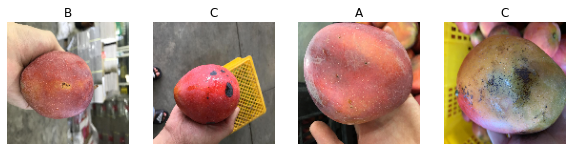

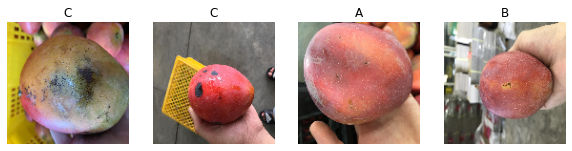

In [0]:
image_batch, label_batch = next(test_generator)
show_batch(image_batch, label_batch)
image_batch, label_batch = next(val_test_generator)
show_batch(image_batch, label_batch)

## 測試一下看一個Batch裡的圖片...

In [0]:
import matplotlib.pyplot as plt
CLASS_NAMES = np.array(['A', 'B', 'C'])
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(4):
      ax = plt.subplot(1,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

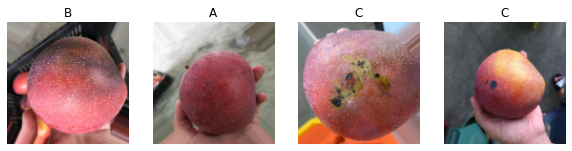

In [0]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

## 設計建立model使用的function

In [0]:
def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1),name=None):
    """Utility function to apply conv + BN.
       example:layers.Conv2D(16,(3,3),
                 strides=(1,1),
                 input_shape=(800, 800, 3),
                 padding='same',
                 activation='relu')
        return: Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    bn_axis = 3 # Channels_last format
    x = layers.Conv2D(filters, 
                      (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=False,
                      name=conv_name)(x)
    x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = layers.Activation('relu', name=name)(x)
    return x

## Let's train.

In [0]:
inputs = layers.Input(shape=(512, 512, 3))
x = conv2d_bn(inputs, 32, 3, 3, strides=(2, 2), padding='same')
x = conv2d_bn(x, 32, 3, 3, strides=(2, 2), padding='same')
x = conv2d_bn(x, 32, 3, 3, padding='same')
x = conv2d_bn(x, 64, 3, 3)
x = conv2d_bn(x, 32, 3, 3, padding='same')
y = conv2d_bn(inputs, 32, 3, 3, strides=(2, 2), padding='same')
y = conv2d_bn(y, 32, 3, 3, strides=(2, 2), padding='same')
mix = keras.layers.concatenate([x, y],name='mixed')
x = layers.MaxPooling2D(pool_size=(2,2),strides=None)(mix)
x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3,activation='softmax')(x)
model = models.Model(inputs, outputs, name='inception_concept')

model.summary()

In [0]:
# 建立深度學習CNN Model
# 此為 sample code 的模型
model = tf.keras.Sequential()

model.add(layers.Conv2D(16,(3,3),
                 strides=(1,1),
                 input_shape=(800, 800, 3),
                 padding='same',
                 activation='relu',
                 ))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 800, 800, 16)      448       
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [0]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(512,512,3))
for layer in resnet.layers:
  layer.trainable = False
'''
res_output = resnet.layers[-1].output
res_output = layers.Flatten()(res_output) # Using keras backend here.
resnet_model = Model(resnet.input, res_output, name='transfer_resnet')
'''

94773248/94765736 [==============================] - 1s 0us/step


"\nres_output = resnet.layers[-1].output\nres_output = layers.Flatten()(res_output) # Using keras backend here.\nresnet_model = Model(resnet.input, res_output, name='transfer_resnet')\n"

In [0]:
# Another way of implementing transfer learning
inputs = layers.Input(shape=(128, 128, 3))
x = resnet(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3,activation='softmax')(x)
model = Model(inputs, outputs, name='transfer_learning')
model.summary()

Model: "transfer_learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 27,782,531
Trainable params: 4,194,819
Non-trainable params: 23,587,712
_____________________________

In [0]:
model = Sequential()
model.add(resnet_model)
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

In [0]:
model.compile(optimizer=optimizers.adam(lr=2e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

In [0]:
# 檔名設定
file_name = '20200525_e94064082_transfer_resnet50'
# 加入EarlyStopping以及Tensorboard等回調函數
CB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
TB = keras.callbacks.TensorBoard(log_dir='./log'+"_"+file_name, histogram_freq=1)

In [0]:
# GPU Setting for keras
from tensorflow.compat.v1.keras.backend import set_session
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto()
config.allow_soft_placement=True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config = config)
set_session(sess)

In [0]:
!nvidia-smi

Mon May 25 15:30:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    65W / 149W |    400MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,  
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[CB],
                    epochs=2)

Epoch 1/2
308/700 [============>.................] - ETA: 35:36 - loss: 1.4939 - acc: 0.5016

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 50 could not be retrieved. It could be because a worker has died.
  UserWarning)


UnidentifiedImageError: ignored

In [0]:
model.save(filename+".h5")